# `flarestack` Test Minimization Notebook

## 1. Directory Setup

In [1]:
import logging
logging.basicConfig(level='INFO')

In [2]:
import os
os.environ['FLARESTACK_SCRATCH_DIR']

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch'

In [3]:
from flarestack.shared import host_server
from flarestack.data.icecube.ic_season import icecube_dataset_dir
print(f'Running at {host_server}, data directory is {icecube_dataset_dir}')

INFO:flarestack.shared:Scratch Directory is: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/pull_corrections/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/logs/
INFO:flarestack.shared:Fou

Running at None, data directory is /Users/thomasahrens/Desktop/IceCube/flarestack/datasets/


In [4]:
from flarestack.shared import fs_scratch_dir
print(f'Scratch directory is {fs_scratch_dir}')

Scratch directory is /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/


## 2. Flarestack Classes

Classes used in $\texttt{flarestack}$'s core functionality (e.g. `flarestack.core.energy_pdf.EnergyPDF`, `flarestack.core.minimisation.MinimisationHandler`, etc) have a class attribute `<class>.subclasses`.  
This is a dictionary with the structure `{<subclass name>: <subclass>}`.  

In [5]:
from flarestack.core.minimisation import MinimisationHandler
MinimisationHandler.subclasses

{'fixed_weights': flarestack.core.minimisation.FixedWeightMinimisationHandler,
 'large_catalogue': flarestack.core.minimisation.LargeCatalogueMinimisationHandler,
 'fit_weights': flarestack.core.minimisation.FitWeightMinimisationHandler,
 'fit_weights_mcmc': flarestack.core.minimisation.FitWeightMCMCMinimisationHandler,
 'fit_weights_hmc': flarestack.core.minimisation.FitWeightHMCMinimisationHandler,
 'flare': flarestack.core.minimisation.FlareMinimisationHandler}

For analyses we only have to pass a dictionary of the subclass names and corresponding parameters.  
To execute use `flarestack.cluster.submitter.Submitter`. This always works locally. For using the cluster, again, if you are running at DESY or WIPAC, you do not have to worry. We got you covered.

In [6]:
from flarestack.cluster.submitter import Submitter
Submitter.submitter_dict

{'local': flarestack.cluster.submitter.LocalSubmitter,
 'DESY': flarestack.cluster.submitter.DESYSubmitter,
 'WIPAC': flarestack.cluster.submitter.WIPACSubmitter}

## 3. Example: Point Source Sensitivity

Let's try to calculate the 10-year point source sensitivity for our test catalogue.  
The input directory (with the analysis dictionaries), the output directory (plots, p-values, etc) and the cache directory (saved trials, etc) will be created accordingly.   
First we have to specify a name for the analysis.

In [7]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
from glob import glob

In [8]:
min_types = ('fixed',  # fixed_weights
             'fit',    # fit_weights
             'mcmc',   # fit_weights_mcmc
             'hmc')    # NotImplemented

def name_func(n_sources, gamma, min_type, scale, trials, etc=None):
    """Creates name for output analysis files. This is motivated
    by the need to inspect run results for debugging purposes, 
    and is achieved by using unique names to refer to each run.
    
    :param n_sources: Number of sources in catalog
    :type n_sources: int
    
    :param gamma: Spectral index
    :type n_sources: float
    
    :param min_type: Minimization method (see MinimisationHandler.subclasses)
    :type n_sources: str
    
    :param etc: Additional simulation/run info
    :type n_sources: str
    
    :return path: Path used as name
    :rtype path: str
    """
    run_no = 1
    
    if min_type not in min_types:
        raise ValueError(f'Provide valid minimizer: {min_types}')
        
    path = f'analyses/{n_sources}source_gamma{gamma}_{min_type}_{scale}_trials{trials}'
    
    if etc is not None:
        path += f'_{etc:s}'
        
    path += f'_run{run_no}'
    
    path_exist = os.path.exists(plot_output_dir(path)) or os.path.exists(name_pickle_output_dir(path))
    
    if path_exist:
        # Automatically covers cases where run_no == (n_sources or gamma)
        glob_path = path.split(f'_run{run_no}')[0]
        # Get all runs with same path
        previous_runs = glob(f'{name_pickle_output_dir(glob_path)}*')
        # Get run numbers for previous runs, convert strings to ints
        run_nums = [int(i.split('_run')[1]) for i in previous_runs]
        # Sort run numbers
        run_nums.sort()
        # Get last run number, increase index by 1
        run_no = run_nums[-1] + 1
        path = f'{glob_path}_run{run_no}'
    else:
        # Path DNE, unchanged path (run 1)
        pass
    
    return path

In [9]:
name = name_func(n_sources=1, gamma=2.0, min_type='fit', 
                 scale='scale1e5', trials=10, etc='NT005_allseasons')
name

'analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1'

Our plot output directories will be:

In [10]:
from flarestack.shared import plot_output_dir, name_pickle_output_dir
plot_output_dir(name), name_pickle_output_dir(name)

('/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1',
 '/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1')

Public 3-year point source data.

In [11]:
from flarestack.data.icecube.northern_tracks import nt_v005_p00
for season in nt_v005_p00.nt_v005_p00:
    print(season)

IC86_2011
IC86_2012
IC86_2013
IC86_2014
IC86_2015
IC86_2016
IC86_2017
IC86_2018
IC86_2019


We want to inject a steady neutrino signal with a power law spectrum with $\gamma=2.5$. For other Energy or Time PDFs check `flarestack.core.energy_pdf` and `flarestack.core.time_pdf`.   \
This is as straight forward as:

In [12]:
import numpy as np
import astropy.units as u

In [13]:
injection_energy = {
    "energy_pdf_name": "power_law",
    "gamma": 2.0
}

# Move decay parameters here
injection_time = {
    "time_pdf_name": "steady",
#     "decay_time": 0.2*u.year.to(u.d),
#     "decay_length": 1*u.year.to(u.d)
}

inj_kwargs = {
    "injection_energy_pdf": injection_energy,
    "injection_sig_time_pdf": injection_time
}

We are looking for a steady signal with a power law spectrum. 
We assume the background to be constant in time.  
We want to use the "standard" point source likelihood. More likelihood implementations in `flarestack.core.llh`

In [14]:
# llh_time = {
#     "time_pdf_name": "decay",
#     "decay_time": 0.2*u.year.to(u.d),
#     "decay_length": 1*u.year.to(u.d)
# }
llh_time = {
    "time_pdf_name": "steady",
}

llh_energy = {
    "energy_pdf_name": "power_law",
}

llh_time_bkg = {
    "time_pdf_name": "steady"
}

llh_kwargs = {
    "llh_name": "standard",
    "llh_energy_pdf": llh_energy,
    "llh_sig_time_pdf": llh_time,
    "llh_bkg_time_pdf": llh_time_bkg
}

We need a source catalogue. This catalogue will be a numpy array stored as a `.npy` file and we only pass the filename.   
For point sources the is a uitility function to generate dummy sources.

In [15]:
import os
catalog_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/catalog/tns_test_catalogue_5_shiftedmore.npy"
catalog = np.load(catalog_path)
catalog
print(f"-- Initial Catalog:\n{catalog}")
print(list(catalog.dtype.fields.keys()))

# Change certain catalogue parameters
source_idx1, source_idx2, source_idx3 = 0, 1, 2
row1, row2, row3 = catalog[source_idx1], catalog[source_idx2], catalog[source_idx3]
row1['dec_rad'], row2['dec_rad'], row3['dec_rad'] = 0.9, 0.5, 0.2
catalog_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/catalog/1_northern.npy"
catalog = catalog[:1]
with open(catalog_path, 'wb') as f:
    np.save(f, catalog)

# Write & load new catalog
print(f"\n-- Final Catalog:\n{catalog}")
print(list(catalog.dtype.fields.keys()))

-- Initial Catalog:
[(3.77254503,  0.079562  , 1., 1., 55393.29888, nan, nan, 2.42161687e+13, b'SN 2022owx')
 (3.54619874,  0.01188783, 1., 1., 55393.25944, nan, nan, 7.74682625e+13, b'SN 2022owp')
 (0.45637582,  0.65794404, 1., 1., 55382.56769, nan, nan, 1.76158814e+13, b'SN 2022ojo')
 (3.52127427, -0.20748469, 1., 1., 55381.75843, nan, nan, 1.99048074e+13, b'SN 2022ogt')
 (5.82823346,  0.65065424, 1., 1., 55376.44572, nan, nan, 1.85568464e+13, b'SN 2022nwx')]
['ra_rad', 'dec_rad', 'base_weight', 'injection_weight_modifier', 'ref_time_mjd', 'start_time_mjd', 'end_time_mjd', 'distance_mpc', 'source_name']

-- Final Catalog:
[(3.77254503, 0.9, 1., 1., 55393.29888, nan, nan, 2.42161687e+13, b'SN 2022owx')]
['ra_rad', 'dec_rad', 'base_weight', 'injection_weight_modifier', 'ref_time_mjd', 'start_time_mjd', 'end_time_mjd', 'distance_mpc', 'source_name']


Now we make a guess for our sensitivity.   
Note: $\texttt{flarestack}$ is using its own scale factor $k$.

In [16]:
from flarestack.shared import flux_to_k, k_to_flux
flux_to_k(1), flux_to_k(1e-9)

(999999999.9999999, 1.0)

Here we know where the sensitivity should be. Because the analysis has been done before.

In [17]:
logging.basicConfig(level='ERROR')
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
scale = flux_to_k(reference_sensitivity(np.sin(catalog['dec_rad']))) * 3
scale

array([2.48747014])

Now we just have to put all the info into one dictionary to pass to the `MinimisationHandler`. Note that our scale guess is informed by the sum over the estimated scales from `flarestack.icecube_utils.reference_sensitivity`. 

In [18]:
mh_dict = {
    "name": name,                                                 # unique name for the analysis
    "mh_name": "fit_weights",                                     # name of the MinimisationHandler subclass
    "dataset": nt_v005_p00.nt_v005_p00.get_seasons(),             # the neutrino dataset
    "catalogue": catalog_path,                                    # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                       # info for the Injector
    "llh_dict": llh_kwargs,                                       # info for the LLH
    "scale": 1e5,                                                 # a guess for the sensitivity scale
    "n_trials": 10,                                               # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 11,                                                # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                        # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

To execute the analysis we defined above we create a submitter instance

In [19]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=7,                                 # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)


----- Submitter for analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1 -----
not using cluster 
using 7 CPUs locally
job-id: None 
no scale estimation 



Energise ......

In [20]:
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86_2011
INFO:flarestack.core.injector:Initialising Injector for IC86_2012
INFO:flarestack.core.injector:Initialising Injector for IC86_2013
INFO:flarestack.core.injector:Initialising Injector for IC86_2014
INFO:flarestack.core.injector:Initialising Injector for IC86_2015
INFO:flarestack.core.injector:Initialising Injector for IC86_2016
INFO:flarestack.core.injector:Initialising Injector for IC86_2017
INFO:flarestack.core.injector:Initialising Injector for IC86_2018
INFO:flarestack.core.injector:Initialising Injector for IC86_2019
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 

INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2017_scale20000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2018_scale20000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2019_scale20000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:90 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2011_scale30000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/de

INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2014_scale60000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:52 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2015_scale60000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:51 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2016_scale60000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2017_scale60000.0_sig.pickle
INFO:flarestack.core.multiprocess_wr

INFO:flarestack.core.multiprocess_wrapper:23 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2017_scale90000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:23 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2018_scale90000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:20 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/IC86_2019_scale90000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:20 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:20 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:17 tasks remaining

To get the results we use the `ResultsHandler()`. This will also create some plots like the sensitivity fit, bias plots, etc. in the plot directory. If `OverfluctuationError`, set `do_sens=False` and `do_disc=False` in `ResultsHandler()` object. If you get a `NotaDirectoryError` from `results.py`, may need to change named seasons (`results.py:296`).

In [21]:
from flarestack.core.results import ResultsHandler

In [22]:
if mh_dict['scale'] <= 1e3:
    results_handler = ResultsHandler(submitter.mh_dict)
    print(fr'sensitivity flux: {results_handler.sensitivity:<10.2e} '
          fr'+{results_handler.sensitivity_err[1]:<10.2e} '
          fr'-{results_handler.sensitivity_err[0]:<10.2e}')
    print(fr'sensitivity n_s:  {results_handler.sensitivity * results_handler.flux_to_ns:<10.2e} '
          fr'+{results_handler.sensitivity_err[1] * results_handler.flux_to_ns:<9.4f}  '
          fr'-{results_handler.sensitivity_err[0] * results_handler.flux_to_ns:<9.4f}')
else:
    results_handler = ResultsHandler(submitter.mh_dict, do_sens=False, do_disc=False)

/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/5E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/4E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/6E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/7E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/3E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/1E+05
/Users/thomasahr

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/bias_n_s (b'SN 2022owx').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/1source_gamma2.0_fit_scale1e5_trials10_NT005_allseasons_run1/bias_gamma.pdf


# Repeat analysis using MCMC
`n_trials` has been reduced in order to run this notebook more easily, `n_trials = 100` has been used for testing purposes.

### Find MCMC seed values

Seed the MCMC around the maximum LLH fround by the `fit_weights` minimizer. Copy `mu` and `std` lists into MCMC minimizer class.

In [23]:
from glob import glob
import pickle

In [24]:
def means_and_dev(name):
    """Calculates mean and standard deviation from `fit_weights` minimizer
    to then be input into `fit_weights_mcmc` minimizer.
    
    :param name: Analysis run name
    :type name: str
    
    :return mu: List of average parameter (n_s, gamma) values
    :rtype mu: list
    
    :return std: List of parameter (n_s, gamma) standard deviations
    :rtype std: list
    """
    path_to_pickles = os.path.join(name_pickle_output_dir(name), 'merged')
    pickles = glob(os.path.join(path_to_pickles, '*.pkl'))
    key_arrays = {}
    
    for pkl in pickles:
        pickle_path = pkl

        with open(pickle_path, 'rb') as file:
            pickle_data = pickle.load(file)

        if not key_arrays:
            key_arrays = {key:[] for key in pickle_data['Parameters'].keys()}

        for key, data in pickle_data['Parameters'].items():
            key_arrays[key].append(data)
        
    mu = []
    std = []

    for key, data in key_arrays.items():
        key_arrays[key] = np.array(sum(key_arrays[key], []))
        mu.append(float(f'{np.mean(key_arrays[key]):0.4f}'))
        std.append(float(f'{np.std(key_arrays[key]):0.4f}'))

    return mu, std

In [25]:
mu, std = means_and_dev(name)
print(f'mu:  {mu}')
print(f'std: {std}')

mu:  [501.2425, 2.2581]
std: [498.7667, 0.6215]


### Setup MCMC

In [26]:
name = name.replace('fit', 'mcmc')
name

'analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1'

In [27]:
mh_dict['name'] = name
mh_dict['mh_name'] = 'fit_weights_mcmc'
mh_dict['mu'] = mu
mh_dict['std'] = std
mh_dict['nwalkers'] = 15

In [28]:
mh_dict

{'name': 'analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1',
 'mh_name': 'fit_weights_mcmc',
 'dataset': <flarestack.data.icecube.ic_season.IceCubeDataset at 0x17b1bfcd0>,
 'catalogue': '/Users/thomasahrens/Desktop/IceCube/sn-search/catalog/1_northern.npy',
 'inj_dict': {'injection_energy_pdf': {'energy_pdf_name': 'power_law',
   'gamma': 2.0},
  'injection_sig_time_pdf': {'time_pdf_name': 'steady'}},
 'llh_dict': {'llh_name': 'standard',
  'llh_energy_pdf': {'energy_pdf_name': 'power_law'},
  'llh_sig_time_pdf': {'time_pdf_name': 'steady'},
  'llh_bkg_time_pdf': {'time_pdf_name': 'steady'}},
 'scale': 100000.0,
 'n_trials': 10,
 'n_steps': 11,
 'allow_extrapolated_sensitivity': True,
 'mu': [501.2425, 2.2581],
 'std': [498.7667, 0.6215],
 'nwalkers': 15}

In [29]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=7,                                 # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

In [30]:
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86_2011
INFO:flarestack.core.injector:Initialising Injector for IC86_2012
INFO:flarestack.core.injector:Initialising Injector for IC86_2013
INFO:flarestack.core.injector:Initialising Injector for IC86_2014
INFO:flarestack.core.injector:Initialising Injector for IC86_2015
INFO:flarestack.core.injector:Initialising Injector for IC86_2016
INFO:flarestack.core.injector:Initialising Injector for IC86_2017
INFO:flarestack.core.injector:Initialising Injector for IC86_2018
INFO:flarestack.core.injector:Initialising Injector for IC86_2019
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrappe

INFO:flarestack.core.multiprocess_wrapper:173 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:172 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:172 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:171 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:170 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:169 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:168 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:166 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:165 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:165 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:165 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:165 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:164 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:160 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:160 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:158 tasks rem

INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2015_scale20000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2016_scale20000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:96 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2017_scale20000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2018_scale20000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratc

INFO:flarestack.core.multiprocess_wrapper:78 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:77 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2011_scale40000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:76 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2012_scale40000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2013_scale40000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:76 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1sou

INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2012_scale50000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:66 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2013_scale50000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2014_scale50000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:66 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2015_scale50000.0_sig.pickle
INFO:flarestack.core.multiproces

INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2014_scale60000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:55 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2015_scale60000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:55 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2016_scale60000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:55 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86

INFO:flarestack.core.multiprocess_wrapper:48 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:48 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:47 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:47 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:47 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:46 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2011_scale70000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:46 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2012_scale70000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:46 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flare

INFO:flarestack.core.multiprocess_wrapper:38 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:38 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:38 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:38 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:37 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:37 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2011_scale80000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:36 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2012_scale80000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e

INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2014_scale90000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2015_scale90000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:26 tasks remaining.
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2016_scale90000.0_sig.pickle
INFO:flarestack.core.injector:Wrote file /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/debug_realizations/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/IC86_2017_scale90000.0_sig.pickle
INFO:flarestack.core.multiprocess_wrapper:26 tasks remaining.
INFO:flarestack.core.injector:Wr

INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:16 tasks remaining.
INFO:fla

INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.multiprocess_wrapper:8 tasks remaining.
INFO:flarestack.core.mul

In [31]:
if mh_dict['scale'] <= 1e3:
    results_handler = ResultsHandler(submitter.mh_dict)
    print(fr'sensitivity flux: {results_handler.sensitivity:<10.2e} '
          fr'+{results_handler.sensitivity_err[1]:<10.2e} '
          fr'-{results_handler.sensitivity_err[0]:<10.2e}')
    print(fr'sensitivity n_s:  {results_handler.sensitivity * results_handler.flux_to_ns:<10.2e} '
          fr'+{results_handler.sensitivity_err[1] * results_handler.flux_to_ns:<9.4f}  '
          fr'-{results_handler.sensitivity_err[0] * results_handler.flux_to_ns:<9.4f}')
else:
    results_handler = ResultsHandler(submitter.mh_dict, do_sens=False, do_disc=False)

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/bias_n_s (b'SN 2022owx').pdf


/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/5E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/4E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/6E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/7E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/3E+04
/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/1E+05
/Users/tho

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/1source_gamma2.0_mcmc_scale1e5_trials10_NT005_allseasons_run1/bias_gamma.pdf


## 4. MCMC Analysis Plots

In [32]:
import pickle
import corner
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [33]:
mpl.rcParams['figure.dpi'] = 300

In [34]:
mcmc_pickle_path = os.path.join(name_pickle_output_dir(name), 'chains.pkl')

with open(mcmc_pickle_path, 'rb') as file:
    mcmc_pickle = pickle.load(file)
    
mcmc_pickle.shape

(9916, 15, 2)

In [35]:
def labels(name):
    corner_labels = []
    for source in range(len(catalog)):
        corner_label = catalog[source]['source_name'].decode()
        corner_labels.append('n_s: ' + corner_label)
    corner_labels.append('gamma')
    
    return corner_labels

### Corner Plot

In [36]:
def corner_plot(name, save_fig=False, **kwargs):
    
    corner_labels = labels(name)

    truths = np.append(scale / 3, injection_energy['gamma'])
    
    corner_kwargs = dict(
        bins=30,
        labels=corner_labels,
        quantiles=[0.16, 0.5, 0.84],
        truths=truths,
        use_math_text=True,
        show_titles=True, 
        title_kwargs={"fontsize": 10},
        truth_color='#4682b4',
        plot_datapoints=False, 
        fill_contours=True,
    )
    
    for key, value in kwargs.items():
        corner_kwargs[key] = value
    
    ndim = len(catalog) + 1
    
    reshaped_steps = mcmc_pickle.reshape((-1,ndim))
    
    fig = corner.corner(reshaped_steps, 
                        **corner_kwargs)
    
    if save_fig:
        plt.savefig(os.path.join(plot_output_dir(name), 'corner.png'), dpi=300)

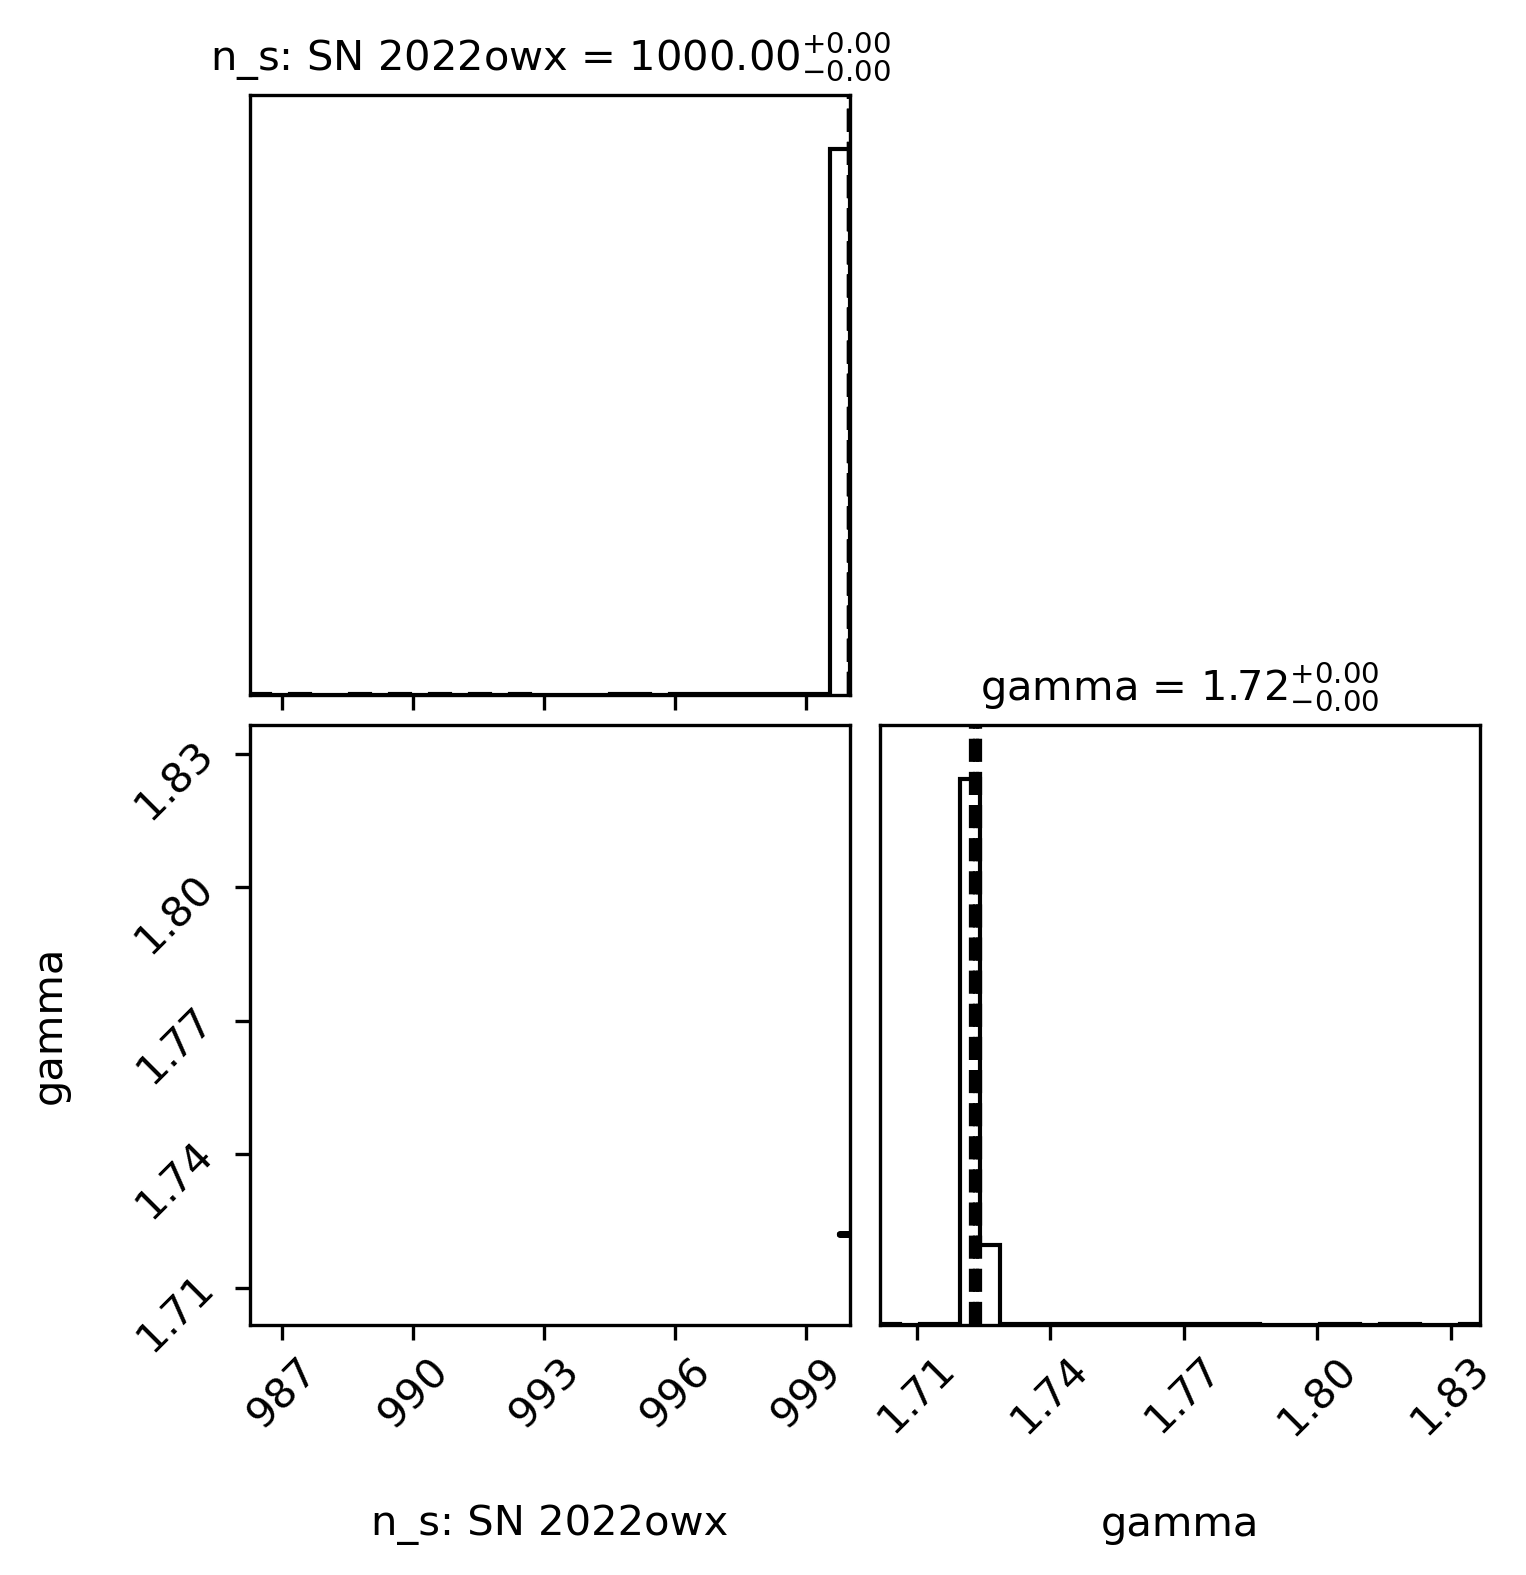

In [37]:
corner_plot(name, save_fig=True)

### Walker Steps

In [38]:
def walker_plot(name, n_steps=len(mcmc_pickle), save_fig=False):
    ndim = len(catalog) + 1
    fig, axes = plt.subplots(ndim, figsize=(15, 8), sharex=True)
    # samples = sampler.get_chain()
    walker_labels = labels(name)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(mcmc_pickle[:, :, i], "k", alpha=0.1)
        ax.set_xlim(0, len(mcmc_pickle[:n_steps]))
        ax.set_ylabel(walker_labels[i], rotation=0, ha='right')
        ax.yaxis.set_label_coords(-0.05, 0.5)

    axes[-1].set_xlabel("step number")
    fig.tight_layout
    
    if save_fig:
        plt.savefig(os.path.join(plot_output_dir(name), 'walkers.png'), dpi=300)

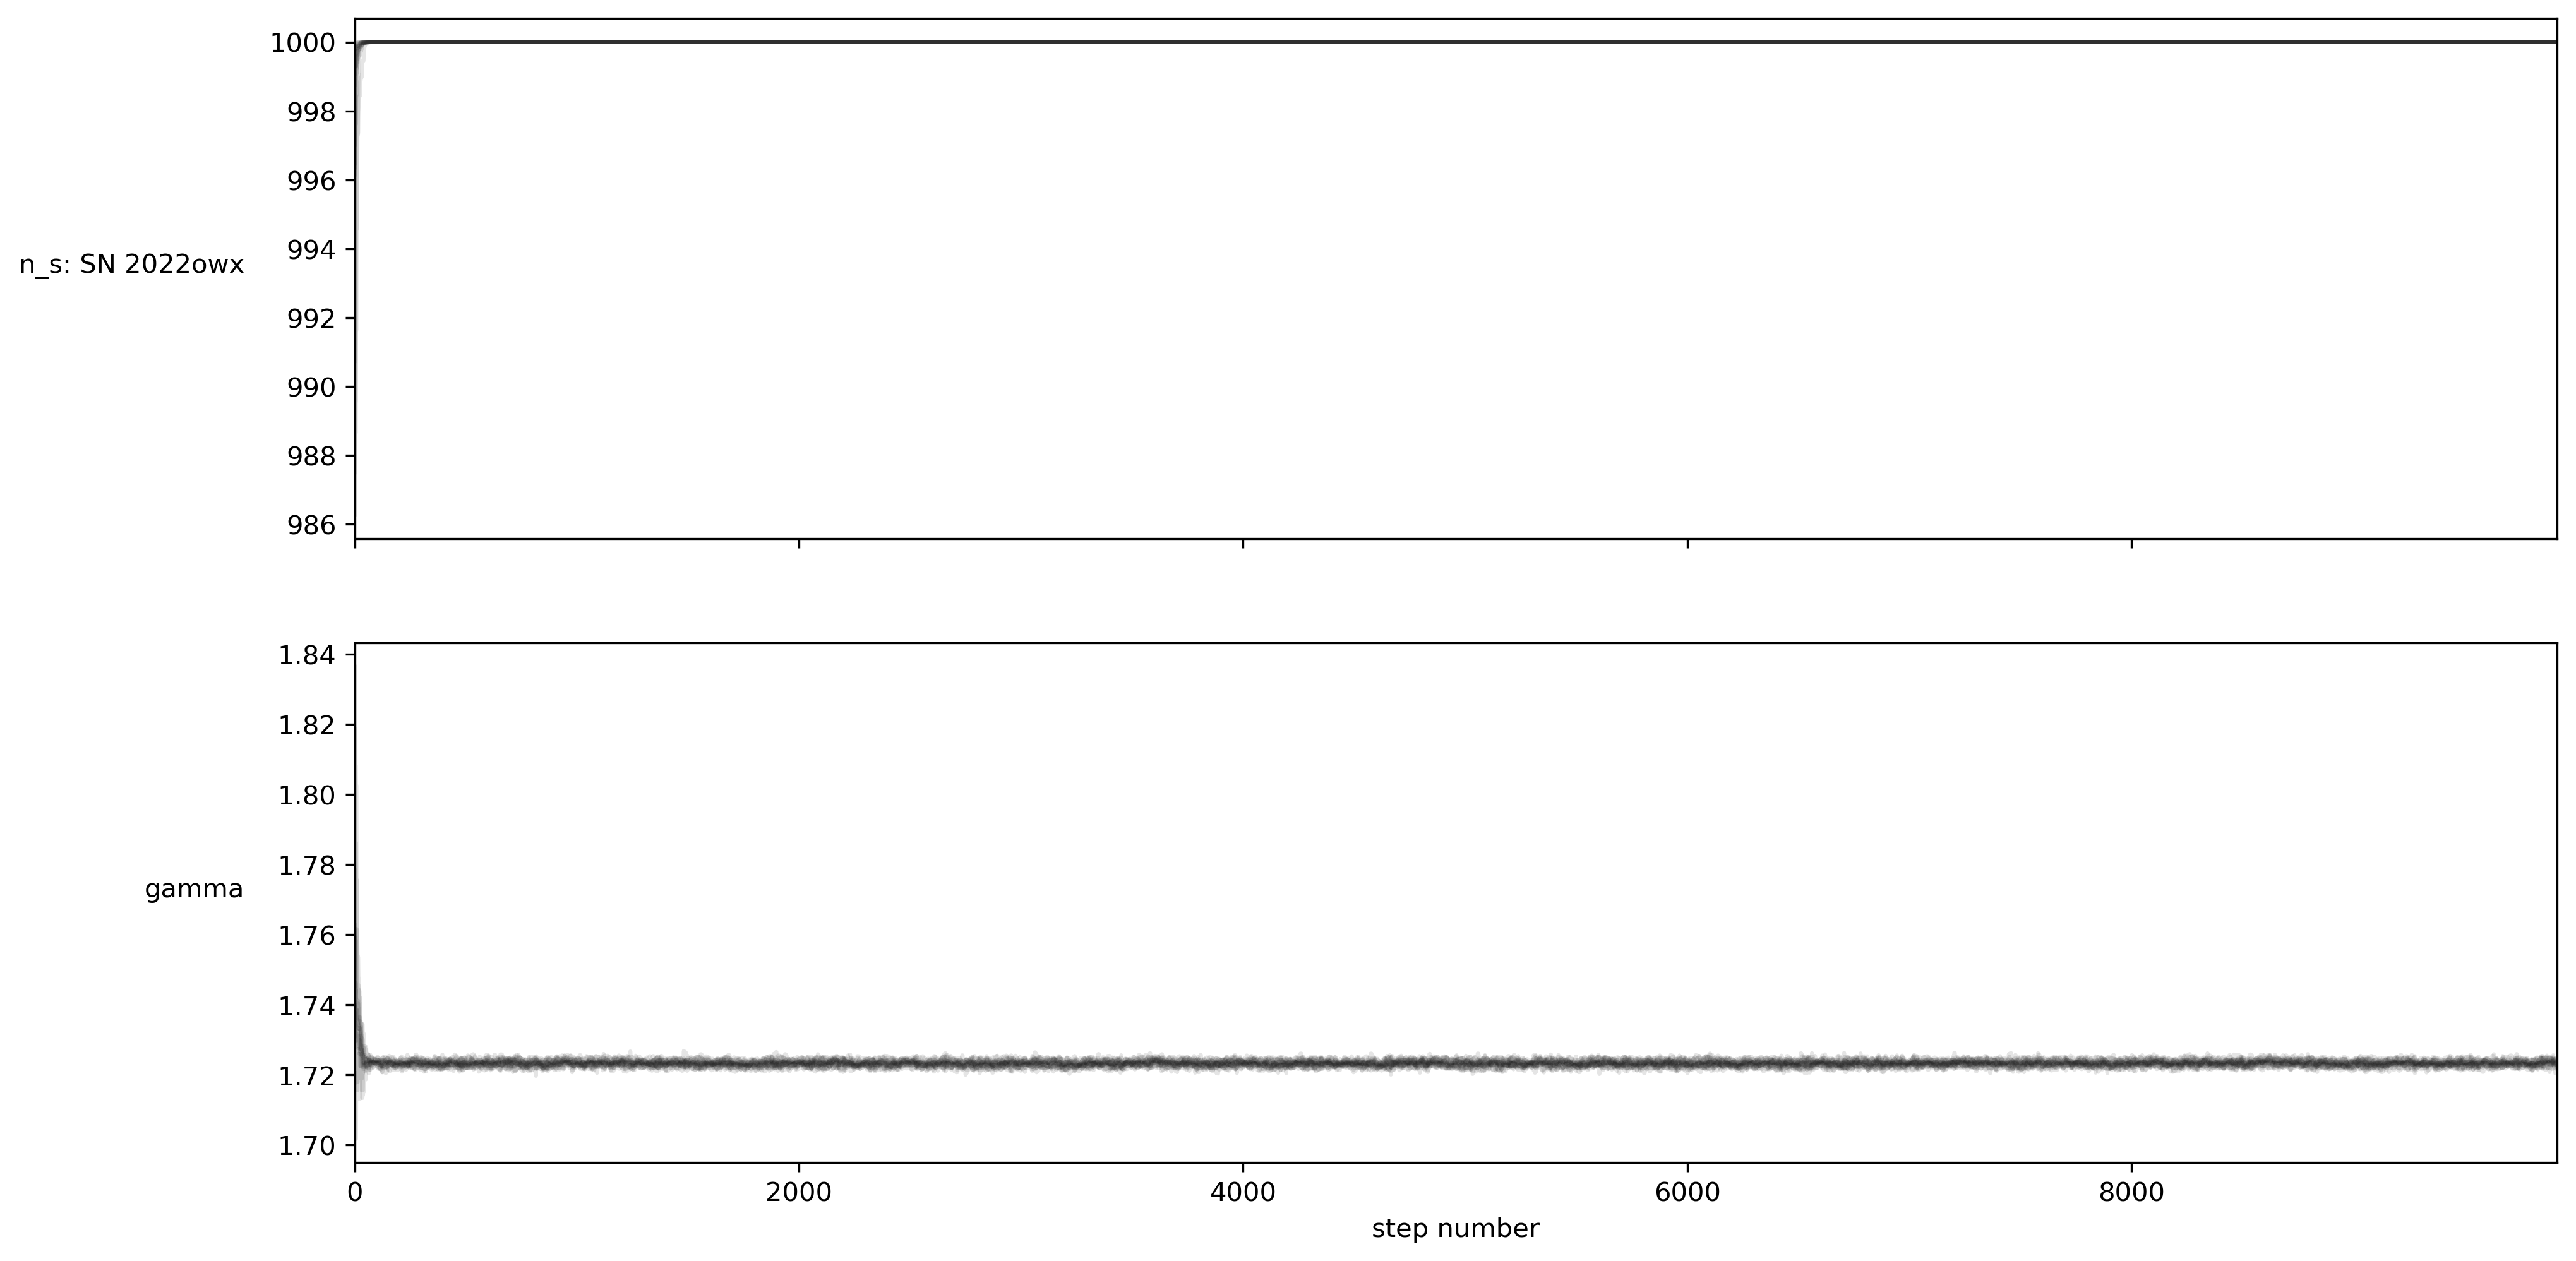

In [39]:
walker_plot(name, save_fig=True)